In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [3]:
class LoadingData():
            
    def __init__(self):
        train_file_path = os.path.join("..","input","nlp-benchmarking-data-for-intent-and-entity","benchmarking_data","Train")
        validation_file_path = os.path.join("..","input","nlp-benchmarking-data-for-intent-and-entity","benchmarking_data","Validate")
        category_id = 0
        self.cat_to_intent = {}
        self.intent_to_cat = {}
        
        for dirname, _, filenames in os.walk(train_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                self.cat_to_intent[category_id] = intent_id
                self.intent_to_cat[intent_id] = category_id
                category_id+=1
        print(self.cat_to_intent)
        print(self.intent_to_cat)
        '''Training data'''
        training_data = list() 
        for dirname, _, filenames in os.walk(train_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                training_data+=self.make_data_for_intent_from_json(file_path,intent_id,self.intent_to_cat[intent_id])
        self.train_data_frame = pd.DataFrame(training_data, columns =['query', 'intent','category'])   
        
        self.train_data_frame = self.train_data_frame.sample(frac = 1)


        
        '''Validation data'''
        validation_data = list()    
        for dirname, _, filenames in os.walk(validation_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                validation_data +=self.make_data_for_intent_from_json(file_path,intent_id,self.intent_to_cat[intent_id])                
        self.validation_data_frame = pd.DataFrame(validation_data, columns =['query', 'intent','category'])

        self.validation_data_frame = self.validation_data_frame.sample(frac = 1)
        
        
    def make_data_for_intent_from_json(self,json_file,intent_id,cat):
        json_d = json.load(open(json_file))         
        
        json_dict = json_d[intent_id]

        sent_list = list()
        for i in json_dict:
            each_list = i['data']
            sent =""
            for i in each_list:
                sent = sent + i['text']+ " "
            sent =sent[:-1]
            for i in range(3):
                sent = sent.replace("  "," ")
            sent_list.append((sent,intent_id,cat))
        return sent_list

In [4]:
load_data_obj = LoadingData()

{0: 'PlayMusic', 1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'RateBook', 4: 'SearchScreeningEvent', 5: 'SearchCreativeWork', 6: 'GetWeather'}
{'PlayMusic': 0, 'AddToPlaylist': 1, 'BookRestaurant': 2, 'RateBook': 3, 'SearchScreeningEvent': 4, 'SearchCreativeWork': 5, 'GetWeather': 6}


In [5]:
load_data_obj.train_data_frame.head(20)

,query,intent,category
8897,I need to know what theatre is playing A Happy...,SearchScreeningEvent,4
2939,Add Marianne Faithfull to june's Hillary Clint...,AddToPlaylist,1
10512,Look for the Editor & Publisher TV series,SearchCreativeWork,5
4110,Can you book a table for a party of 6 close to...,BookRestaurant,2
10287,Show me a novel by Onnaam Muhurtham,SearchCreativeWork,5
10191,Find a show called Chompa Toung .,SearchCreativeWork,5
1308,Play 1958 music on Iheart,PlayMusic,0
4190,book me a diner close-by Benin that serves str...,BookRestaurant,2
9265,is Tarzan of the Apes playing at Cobb Theatres,SearchScreeningEvent,4
7047,Give zero stars to Book of Artifacts,RateBook,3


In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(load_data_obj.train_data_frame['query'], load_data_obj.train_data_frame['category'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=load_data_obj.train_data_frame['category'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

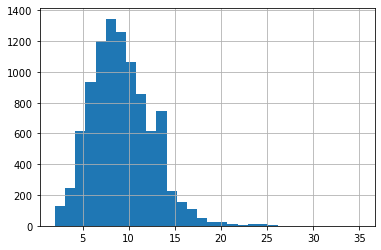

In [8]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [9]:
max_seq_len = max(seq_len)
print(max_seq_len)

35


In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [13]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [14]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,7)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [15]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [16]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [17]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.9844898  1.01419111 0.99803455 1.00678284 1.00531416 1.0075188
 0.9844898 ]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=6623     3
7940     4
3130     1
8301     4
9538     4
        ..
11786    6
8366     4
1098     0
7145     3
8771     4
Name: category, Length: 9648, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [18]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [19]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [20]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [21]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...
  Batch    50  of     65.

Training Loss: 1.364
Validation Loss: 0.743

 Epoch 2 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...
  Batch    50  of     65.

Training Loss: 0.665
Validation Loss: 0.524

 Epoch 3 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...
  Batch    50  of     65.

Training Loss: 0.495
Validation Loss: 0.354

 Epoch 4 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...
  Batch    50  of     65.

Training Loss: 0

In [22]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [24]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       300
           1       0.99      0.92      0.96       292
           2       0.99      0.97      0.98       296
           3       1.00      0.97      0.98       293
           4       0.95      0.88      0.91       294
           5       0.80      0.83      0.81       293
           6       0.98      1.00      0.99       300

    accuracy                           0.93      2068
   macro avg       0.94      0.93      0.93      2068
weighted avg       0.94      0.93      0.93      2068



In [25]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
0,283,1,0,0,0,16,0
1,18,269,0,0,0,5,0
2,0,0,288,0,4,3,1
3,1,0,0,284,0,8,0
4,1,0,1,0,259,29,4
5,35,1,1,1,10,244,1
6,0,0,0,0,0,1,299


In [31]:
device = torch.device("cpu")
bert = AutoModel.from_pretrained('bert-base-uncased')
predict_model = BERT_Arch(bert)
PATH = 'saved_weights.pt'
predict_model.load_state_dict(torch.load(PATH,map_location=device))
predict_model.eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [34]:
def predict(text):
    
    tag = {0: 'PlayMusic', 1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'RateBook', 4: 'SearchScreeningEvent', 5: 'SearchCreativeWork', 6: 'GetWeather'}
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:max_seq_len - 2]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = input_ids + [0] * (max_seq_len-len(input_ids))
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    input_ids = input_ids.to(device)
    
    input_mask = [1]*len(tokens) + [0] * (max_seq_len - len(tokens))
    input_mask = torch.tensor(input_mask).unsqueeze(0)
    input_mask = input_mask.to(device)
    
    logits = predict_model(input_ids,input_mask)
    prob = torch.nn.functional.softmax(logits,dim=1)

    result = [(tag[idx],item *100) for idx,item in enumerate(prob[0].tolist())]
    preds = logits.detach().cpu().numpy()
    pred= np.argmax(preds)
    pred = tag[pred]
    return result,pred
    

In [35]:
list_input = ["Play music from my relentless playlist",
             "I rate this essay a four of 6"]

for item in list_input:
    confidence,pred = predict(item)
    print(pred)
    print(confidence)

PlayMusic
[('PlayMusic', 63.8660192489624), ('AddToPlaylist', 27.898043394088745), ('BookRestaurant', 0.0010027655662270263), ('RateBook', 0.00017184247553814203), ('SearchScreeningEvent', 1.0745170526206493), ('SearchCreativeWork', 7.160063087940216), ('GetWeather', 0.00016551369981243624)]
RateBook
[('PlayMusic', 0.00017648445691520465), ('AddToPlaylist', 0.0045816614147042856), ('BookRestaurant', 0.0001809655600482074), ('RateBook', 99.99027252197266), ('SearchScreeningEvent', 0.0006467956154665444), ('SearchCreativeWork', 0.0032689647923689336), ('GetWeather', 0.0008836677807266824)]
